# Natural Images Dataset

A selection of natural images from [here](https://www.kaggle.com/prasunroy/natural-images) with 8 classes:

- Airplane 
- Car 
- Cat 
- Dog 
- Flower 
- Fruit 
- Motorbike 
- Person 

The goal here is to replicate the use of the fastai library from lessons 1 and 2 on a new dataset

In [32]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *

### Files and Folders

Get a look at what data we have and the folder structure, segment data into training and validation with a 50-50 split.

In [2]:
# Take a look at folders and contents
PATH = "../../../data/natural_images/"
for data_class in os.listdir(f'{PATH}classes'):
    print(data_class, len(os.listdir(f'{PATH}classes/{data_class}')))

airplane 727
person 986
cat 885
motorbike 788
car 968
dog 702
flower 843
fruit 1000


'airplane_0101.jpg'

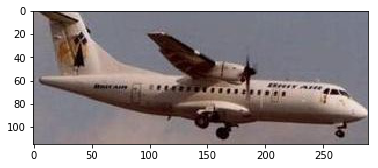

In [3]:
# Sample a random image
data_class = random.choice(os.listdir(f'{PATH}classes'))
img_files = os.listdir(f'{PATH}classes/{data_class}')
idx = random.randint(0, len(img_files) -1 )
img_file = img_files[idx]
img = plt.imread(f'{PATH}classes/{data_class}/{img_file}')
plt.imshow(img)
img_file

In [4]:
# Split folders into train / valid
!mkdir -p {PATH}/train
!mkdir -p {PATH}/valid
!rm -rf {PATH}/valid/*
!rm -rf {PATH}/train/*
!ls {PATH} 
for cls in os.listdir(f'{PATH}/classes'):
    os.mkdir(f'{PATH}/train/{cls}')
    os.mkdir(f'{PATH}/valid/{cls}')
    images = os.listdir(f'{PATH}/classes/{cls}')
    for img in images[0:500]:
        shutil.copyfile(f'{PATH}/classes/{cls}/{img}', f'{PATH}/train/{cls}/{img}')
    for img in images[500:]:
        shutil.copyfile(f'{PATH}/classes/{cls}/{img}', f'{PATH}/valid/{cls}/{img}')

classes  models  tmp  train  valid


In [148]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [149]:
# Use side on transforms to augment the data
image_size=224
batch_size=16
arch=resnet34
transforms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=transforms, bs=16)

In [150]:
# Use "precomputed activations" to cache some stuff to make it a little faster
learn = ConvLearner.pretrained(arch, data)

In [151]:
# Find learning rate
learning_rate_finder = learn.lr_find()

 83%|████████▎ | 207/250 [00:23<00:03, 11.29it/s, loss=1.24] 

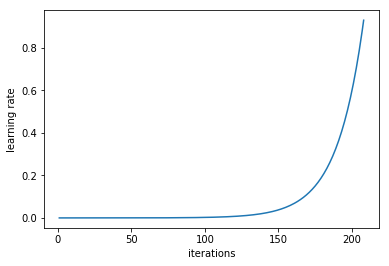

In [152]:
# Plot learning rate as a function of iterations
learn.sched.plot_lr()

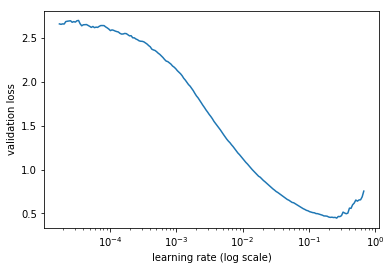

In [153]:
# Plot validation loss as a function of learning rate
learn.sched.plot()

In [154]:
# Choose an aggressive learning rate of 0.5 
# Use a cycle length of 1 so that we "restart" the learning rate after each epoch
# Train last layer of the pre-trained network on the dataset
lr = 0.05
%time learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.116053   0.015435   0.994136  
    1      0.074517   0.008429   0.99793                      
    2      0.08131    0.005742   0.99793                      
CPU times: user 6min 4s, sys: 10min 15s, total: 16min 20s
Wall time: 2min 3s


[array([0.00574]), 0.997930320800276]

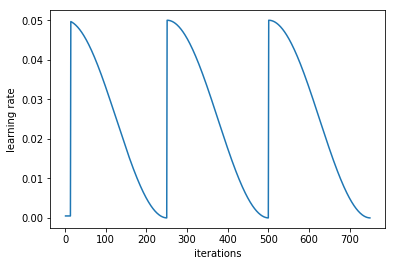

In [155]:
# We can see how the learning rate has been modulated over each cycle (one cycle may be multiple epochs)
learn.sched.plot_lr()

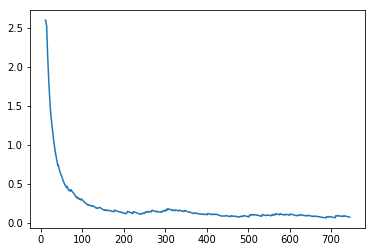

In [156]:
learn.sched.plot_loss()

In [157]:
# We've done iters 1, 2, 3, 4
learn.save('244_natural_images_iter_4')

In [158]:
learn.load('244_natural_images_iter_4')

In [159]:
# Unfreeze all layers, re-investigate optimal learning rate
learn.unfreeze()
learn.lr_find()

 43%|████▎     | 108/250 [00:28<00:34,  4.11it/s, loss=0.417]

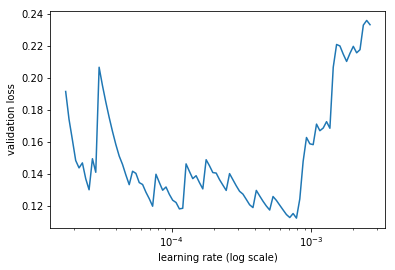

In [160]:
learn.sched.plot()

In [161]:
# Re train on unfrozen network
lr = 0.0005
lrs = np.array([lr / 9, lr / 3, lr])
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.119287   0.025805   0.994481  
    1      0.118988   0.016782   0.995861                     
    2      0.067265   0.017402   0.996206                     
    3      0.085922   0.017996   0.995516                     
    4      0.063094   0.014786   0.996895                     
    5      0.05029    0.013139   0.99724                      
    6      0.037167   0.01914    0.995171                     
CPU times: user 23min 7s, sys: 43min 42s, total: 1h 6min 49s
Wall time: 9min 2s


[array([0.01914]), 0.9951707485339772]

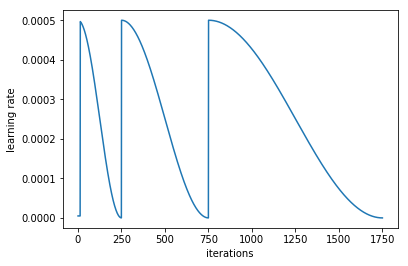

In [162]:
learn.sched.plot_lr()

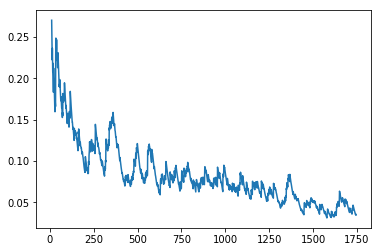

In [163]:
learn.sched.plot_loss()

In [164]:
learn.save('244_natural_images_unfrozen_iter_4')

In [165]:
learn.load('244_natural_images_unfrozen_iter_4')

In [166]:
# Labels for validation data
data.val_y

array([0, 0, 0, ..., 7, 7, 7])

In [167]:
data.classes

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

In [168]:
# Predictions for the validation set. Predictions are in log scale
log_predictions, y = learn.TTA()
log_predictions.shape

(5, 2899, 8)

In [169]:
log_predictions = np.mean(log_predictions, axis=0)
log_predictions.shape


(2899, 8)

In [170]:
# An array of 8 log-scale predictions, for each validation set image 
log_predictions[:5]

array([[ -0.     , -29.762  , -23.30097, -24.69989, -26.71903, -25.22783, -18.48545, -25.01306],
       [  0.     , -35.82212, -38.22173, -34.83288, -32.89563, -29.85667, -26.67167, -28.19161],
       [  0.     , -30.42621, -29.47304, -28.89822, -24.41452, -25.95197, -24.50309, -27.72496],
       [  0.     , -29.55031, -28.36374, -27.39378, -25.09257, -24.91992, -23.1662 , -26.32612],
       [  0.     , -29.64681, -25.70004, -25.5411 , -25.74403, -22.44629, -23.10157, -26.56459]],
      dtype=float32)

In [ ]:
# Get the predicted class for each validation image
predictions = np.argmax(log_predictions, axis=1)
predictions[:5]

In [ ]:
# We can get the predicted probability of each class
pr_airplane = np.exp(log_predictions[:, 0])        
pr_airplane[:5]

In [ ]:
from fastai.plots import *

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, ceildiv(len(ims), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


def load_img_as_arr(image_idx):
    filename = PATH + data.val_ds.fnames[image_idx]
    return np.array(PIL.Image.open(filename))

def get_random_correct_idxs(class_idx, n=4):
    all_correct_idxs = np.where(predictions == class_idx)[0]
    return np.random.choice(all_correct_idxs, n, replace=False)    

def plot_correct(classname):
    class_idx = data.classes.index(classname)    
    correct_idxs = get_random_correct_idxs(class_idx)

    # Read image arrays from files
    images = [load_img_as_arr(idx) for idx in correct_idxs]

    # Get probability as title for each image
    class_probs = np.exp(log_predictions[:, class_idx])
    title_probs = [class_probs[idx] for idx in correct_idxs]

    print(f'Classified as {classname}')
    return plots(images, titles=title_probs, figsize=(16,8))

def plot_incorrect():
    incorrect_idxs = np.where(predictions != data.val_y)[0]
    images = [load_img_as_arr(idx) for idx in incorrect_idxs]
    print(f'Incorrectly classified')
    return plots(images, rows=5, figsize=(16,8))
              

In [ ]:
plot_correct('airplane')

In [ ]:
plot_correct('dog')

In [ ]:
plot_correct('cat')

In [ ]:
plot_incorrect()

In [ ]:
# Show a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, predictions)
plot_confusion_matrix(cm, data.classes)